In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import PIL

train_transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomAffine(degrees=(-5, 5), translate=(0.1, 0.1), scale=(0.9, 1.1), resample=PIL.Image.BILINEAR),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_set, val_set = torch.utils.data.random_split(dataset, [40000, 10000])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=8)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=False, num_workers=8)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False, num_workers=8)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1428: UserWarning: The parameter 'resample' is deprecated since 0.12 and will be removed in 0.14. Please use 'interpolation' instead.
  "The parameter 'resample' is deprecated since 0.12 and will be removed in 0.14. "


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Files already downloaded and verified


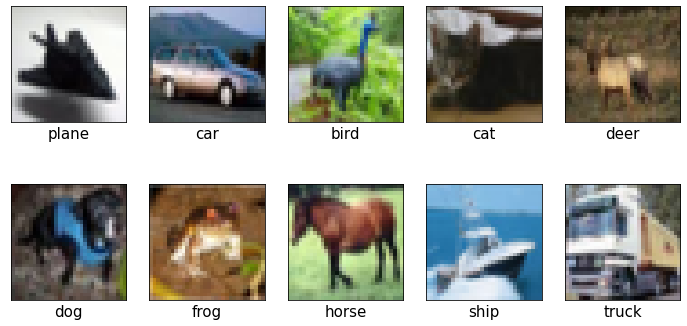

In [3]:
import matplotlib.pyplot as plt
import numpy as np


sample_images = [dataset.data[np.asarray(dataset.targets) == label][0] for label in range(10)]

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
i = 0
for row in axes:
  for axis in row:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel(classes[i], fontsize=15)
    axis.imshow(sample_images[i])
    i += 1

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 128, 5, padding=2)
    self.conv2 = nn.Conv2d(128, 128, 5, padding=2)
    self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
    self.conv4 = nn.Conv2d(256, 256, 3, padding=1)
    self.pool = nn.MaxPool2d(2, 2)
    self.bn_conv1 = nn.BatchNorm2d(128)
    self.bn_conv2 = nn.BatchNorm2d(128)
    self.bn_conv3 = nn.BatchNorm2d(256)
    self.bn_conv4 = nn.BatchNorm2d(256)
    self.bn_dense1 = nn.BatchNorm1d(1024)
    self.bn_dense2 = nn.BatchNorm1d(512)
    self.dropout_conv = nn.Dropout2d(p=0.25)
    self.dropout = nn.Dropout(p=0.5)
    self.fc1 = nn.Linear(256 * 8 * 8, 1024)
    self.fc2 = nn.Linear(1024, 512)
    self.fc3 = nn.Linear(512, 10)
    self.softmax = nn.Softmax(-1)
    

  def conv_layers(self, x):
    out = F.relu(self.bn_conv1(self.conv1(x)))
    out = F.relu(self.bn_conv2(self.conv2(out)))
    out = self.pool(out)
    out = self.dropout_conv(out)
    out = F.relu(self.bn_conv3(self.conv3(out)))
    out = F.relu(self.bn_conv4(self.conv4(out)))
    out = self.pool(out)
    out = self.dropout_conv(out)
    return out

  def dense_layers(self, x):
    out = F.relu(self.bn_dense1(self.fc1(x)))
    out = self.dropout(out)
    out = F.relu(self.bn_dense2(self.fc2(out)))
    out = self.dropout(out)
    out = self.fc3(out)
    
    return out

  def forward(self, x):
    out = self.conv_layers(x)
    out = out.view(-1, 256 * 8 * 8)
    out = self.dense_layers(out)
    return out

net = Net()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)
net.to(device)

num_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("Number of trainable parameters:", num_params)

Device: cuda:0
Number of trainable parameters: 18617482


In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True, min_lr=0)

loss_hist, acc_hist = [], []
loss_hist_val, acc_hist_val = [], []

for epoch in range(10):
  running_loss = 0.0
  correct = 0
  for data in train_loader:
    batch, labels = data
    batch, labels = batch.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = net(batch)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # compute training statistics
    _, predicted = torch.max(outputs, 1)
    correct += (predicted == labels).sum().item()
    running_loss += loss.item()

  avg_loss = running_loss / len(train_set)
  avg_acc = correct / len(train_set)
  loss_hist.append(avg_loss)
  acc_hist.append(avg_acc)

  # validation statistics
  net.eval()
  with torch.no_grad():
    loss_val = 0.0
    correct_val = 0
    for data in val_loader:
      batch, labels = data
      batch, labels = batch.to(device), labels.to(device)
      outputs = net(batch)
      loss = criterion(outputs, labels)
      _, predicted = torch.max(outputs, 1)
      correct_val += (predicted == labels).sum().item()
      loss_val += loss.item()
    avg_loss_val = loss_val / len(val_set)
    avg_acc_val = correct_val / len(val_set)
    loss_hist_val.append(avg_loss_val)
    acc_hist_val.append(avg_acc_val)
  net.train()

  scheduler.step(avg_loss_val)
  print('[epoch %d] loss: %.5f accuracy: %.4f val loss: %.5f val accuracy: %.4f' % (epoch + 1, avg_loss, avg_acc, avg_loss_val, avg_acc_val))




[epoch 1] loss: 0.01420 accuracy: 0.3411 val loss: 0.01190 val accuracy: 0.4421
[epoch 2] loss: 0.01159 accuracy: 0.4587 val loss: 0.01002 val accuracy: 0.5457
[epoch 3] loss: 0.01017 accuracy: 0.5355 val loss: 0.00885 val accuracy: 0.5983
[epoch 4] loss: 0.00894 accuracy: 0.5951 val loss: 0.00748 val accuracy: 0.6588
[epoch 5] loss: 0.00801 accuracy: 0.6404 val loss: 0.00675 val accuracy: 0.6930
[epoch 6] loss: 0.00747 accuracy: 0.6668 val loss: 0.00658 val accuracy: 0.7082
[epoch 7] loss: 0.00701 accuracy: 0.6914 val loss: 0.00581 val accuracy: 0.7459
[epoch 8] loss: 0.00658 accuracy: 0.7093 val loss: 0.00562 val accuracy: 0.7588
[epoch 9] loss: 0.00625 accuracy: 0.7248 val loss: 0.00564 val accuracy: 0.7531
[epoch 10] loss: 0.00602 accuracy: 0.7369 val loss: 0.00500 val accuracy: 0.7835


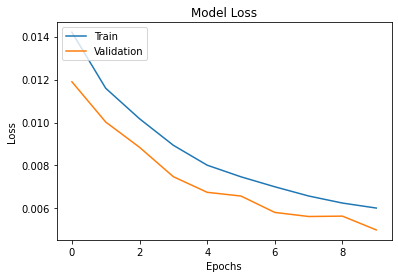

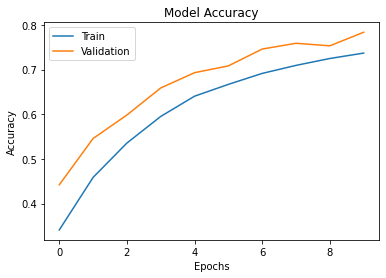

In [6]:
import matplotlib.pyplot as plt

legend = ['Train', 'Validation']
plt.plot(loss_hist)
plt.plot(loss_hist_val)
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(legend, loc='upper left')
plt.show()

legend = ['Train', 'Validation']
plt.plot(acc_hist)
plt.plot(acc_hist_val)
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(legend, loc='upper left')
plt.show()

## Testing

In [7]:
pred_vec = []
correct = 0
net.eval()
with torch.no_grad():
    for data in test_loader:
        batch, labels = data
        batch, labels = batch.to(device), labels.to(device)
        outputs = net(batch)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        pred_vec.append(predicted)
    pred_vec = torch.cat(pred_vec)

print('Accuracy on the 10000 test images: %.2f %%' % (100 * correct / len(test_set)))

Accuracy on the 10000 test images: 78.51 %
